![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [6]:
# Celda 1
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [7]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)    
    return gini_impurity_

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])    
    best_split = [0, 0, 0]  # j, split, gain    
    # Para todas las varibles 
    for j in features:        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)                        
            if gain > best_split[2]:
                best_split = [j, split, gain]    
    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()  
    y_prob = y.mean()     
    tree = dict(y_pred=y_pred,  level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree       
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    # Siguiente iteración para cada partición    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)    
    return tree

In [8]:
tree_grow2=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree_grow(X_train,y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)

{'y_pred': 14508.073389276064,
 'level': 0,
 'split': [0, 2014.0],
 'n_samples': 7031,
 'gain': 17412158.538160443,
 'sl': {'y_pred': 10234.929955947136,
  'level': 1,
  'split': [0, 2012.0],
  'n_samples': 2270,
  'gain': 8039318.299921066,
  'sl': {'y_pred': 8737.28071379547,
   'level': 2,
   'split': [1, 97798.72727272728],
   'n_samples': 1457,
   'gain': 2218560.9485784173,
   'sl': {'y_pred': 9891.465256797583,
    'level': 3,
    'split': -1,
    'n_samples': 662,
    'gain': 1805269.9185358882},
   'sr': {'y_pred': 7776.186163522013,
    'level': 3,
    'split': -1,
    'n_samples': 795,
    'gain': 1238287.4041553736}},
  'sr': {'y_pred': 12918.90897908979,
   'level': 2,
   'split': [1, 73300.81818181818],
   'n_samples': 813,
   'gain': 2615740.375015855,
   'sl': {'y_pred': 13964.06546275395,
    'level': 3,
    'split': -1,
    'n_samples': 443,
    'gain': 942735.5531387925},
   'sr': {'y_pred': 11667.545945945945,
    'level': 3,
    'split': -1,
    'n_samples': 370,
 

## Predicción

In [9]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']            
    else:        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


In [10]:
tree = tree_grow(X_train,y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [11]:
from sklearn.metrics import mean_squared_error
y_pred= tree_predict(X_test,tree)
mse_manual = mean_squared_error(y_test, y_pred)
mse_manual

3690242.262765719

In [12]:
np.sqrt(mean_squared_error(y_test, y_pred))

1921.0003286740268

### Calibración del modelo

Calibraremos el arbol de decisión con el hiperparametro max_depth, evaluandolo con el RMSE.

In [13]:
max_depth_i = range(1,16)
listica= []

for i in list(max_depth_i):
    tree_i = tree_grow(X_train,y_train, level=0, min_gain=0.001, max_depth=i, num_pct=10)
    y_pred_i = tree_predict(X_test,tree_i)
    rmse_i = np.sqrt(mean_squared_error(y_test,y_pred_i))
    listica.append([i,rmse_i])
    
listica  

[[1, 2586.7757224797892],
 [2, 2128.8874044922427],
 [3, 1921.0003286740268],
 [4, 1782.6888801629282],
 [5, 1697.9641986149657],
 [6, 1643.307841242522],
 [7, 1627.4244844155912],
 [8, 1624.788926276523],
 [9, 1648.1078941499732],
 [10, 1692.0998348052804],
 [11, 1754.19719402773],
 [12, 1824.2162653893458],
 [13, 1874.7254157156078],
 [14, 1955.0844428231042],
 [15, 2014.7403396175796]]

In [14]:
tree = tree_grow(X_train,y_train, level=0, min_gain=0.001, max_depth=8, num_pct=10)
y_pred= tree_predict(X_test,tree)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred))

### conclusiones punto 1

En el punto se realiza un modelo de árbol de regresión, debido a que la variable respuesta es continua (precio). Dentro del modelo inicial se entrenan los hiperparámetros de max_depth igual a , level igual a 0 y num_pct igual a igual a 10. A partir de este número de árboles iniciales, se realiza la predicción con respecto al test y se observa un resultado de un MSE de 3.690.242 de forma manual y un valor de RMSE de 1.921 cuando se realiza con la función estipulada. 
Finalmente, se calibra el árbol de decisión a partir del resultado anterior del RMSE y se concluye que el arbol de decisión calibrado con el hiperparametro max_depth = 8, es el arbol manual con el mejor desempeño, teniendo un RMSE de 1624.8

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [15]:
# Celda 2
# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
# número de árboles
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [16]:
# Visualización muestra boostrap #1 para entremiento
X_train.iloc[samples[0], :]

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
151599,2016,40999,0,0,0,0,0,1,0
171999,2014,52527,0,0,0,0,0,1,0
304172,2009,123202,0,1,0,0,0,0,0
74828,2015,38807,0,0,0,0,0,1,0
192974,2005,51260,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
134843,2014,22221,0,0,0,0,1,0,0
325075,2013,86593,0,0,0,0,0,1,0
61213,2014,28044,0,0,0,0,0,1,0
181222,2016,49368,0,0,0,0,0,0,1


In [17]:
# Construcción un árbol de decisión para cada muestra boostrap

# Definición del modelo usando DecisionTreeRegressor de sklearn, con el hiperparametro calibrado
treereg = DecisionTreeRegressor(max_depth=8, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_new_train = X_train.iloc[sample]
    y_new_train = y_train.iloc[sample]
    treereg.fit(X_new_train, y_new_train)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
257343,13147.696429,13509.519685,11837.588235,12892.266990,13624.828704,11765.937500,13837.657609,13280.682759,13142.787234,13203.853846
326011,6288.976471,6489.347826,6159.640000,6371.062500,6095.476190,6800.933333,6691.705882,6662.642857,6261.939759,6761.302326
242354,16232.909722,15814.827939,16193.278481,15861.475000,16147.644068,15698.556627,15879.113208,15754.428571,15943.886105,16340.280374
266376,17070.305000,16850.743655,17895.533333,17822.955056,17787.144578,18097.709677,16830.796392,18059.366667,17057.967213,16847.272727
396954,17070.305000,17239.474576,16551.178082,17822.955056,17075.571429,17348.440678,16833.578431,17428.200000,16754.057692,16044.426934
...,...,...,...,...,...,...,...,...,...,...
144298,16104.870240,16241.830097,16245.350814,15902.112403,16241.647929,16195.857143,16054.710794,16197.127473,16031.271709,16090.024138
364521,17070.305000,16241.830097,16862.623529,17103.097222,17787.144578,16722.290909,16054.710794,16197.127473,18612.031250,16090.024138
120072,18448.168750,18127.543554,18549.422819,17833.224490,18494.800000,18450.835897,18567.285714,18649.809524,18147.172043,18517.551220
99878,12272.583893,13157.261905,12941.882353,12892.266990,12075.143713,12344.744361,12751.000000,12620.648649,12923.296296,12143.479675


In [18]:
# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))

Árbol  0 tiene un error:  1682.2758728398326
Árbol  1 tiene un error:  1687.1750457322878
Árbol  2 tiene un error:  1697.3352876456568
Árbol  3 tiene un error:  1664.1597137353954
Árbol  4 tiene un error:  1679.3238846904433
Árbol  5 tiene un error:  1705.323015158089
Árbol  6 tiene un error:  1707.9187651653226
Árbol  7 tiene un error:  1759.0200382151445
Árbol  8 tiene un error:  1710.7723017757035
Árbol  9 tiene un error:  1693.533920436485


In [19]:
# Predicciones promedio para cada obserbación del set de test
y_pred.mean(axis=1)

257343    13024.281899
326011     6458.302714
242354    15986.640009
266376    17431.979430
396954    17016.818788
              ...     
144298    16130.480274
364521    16874.118499
120072    18378.581401
99878     12612.230783
387162    11645.139495
Length: 3464, dtype: float64

In [20]:
# Error al promediar las predicciones de todos los árboles
rmse_bag = np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))
rmse_bag

1586.8674483919415

### conclusiones punto 2

Al entrenar un modelo bagging inicialmente con 10 árboles de decisión y al analizar los resultados, se observa que particularmente el árbol que menor error presenta es el número 3 con un RMSE de 1664, sin embargo al promediar los resultados de desempeño total, se observa que se tiene un RMSE de 1586. 

Comparando con los resultados del primer punto, donde se calibró un único árbol de decisión manual, se observa que el modelo Bagging manual, con el hiperparametro calibrado del arbol de decisión manual tiene un mejor desempeño que un único arbol manual.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [21]:
features = (X_train.shape)[1]
n_features = max(1, int(np.log2(features)))

In [22]:
# Celda 3
bagreg = BaggingRegressor(DecisionTreeRegressor(max_depth=8, random_state=123), n_estimators=10, max_features=n_features,
                          bootstrap=True, oob_score=True, random_state=1)

In [23]:
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([13251.27919828,  9010.83429281, 16149.16659194, ...,
       17437.70057278, 12296.9701546 , 12684.59672609])

In [24]:
rmse_bag2= np.sqrt(mean_squared_error(y_test, y_pred))
rmse_bag2

1974.026206635597

### conclusiones punto 3

Al realizar el entrenamiento y probar el desempeño con respecto al test, se observa que el modelo bagging con librería no presenta una mejoría con respecto al modelo bagging manual ya que su RMSE es mayor (1.974), esto teniendo en cuennta que ambos modelos contienen los mismos hiperparámetros con el fin de poder ser comparados.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [25]:
# Celda 4
dtr = RandomForestRegressor()
dtr.fit(X_train, y_train)

RandomForestRegressor()

In [26]:
y_pred = dtr.predict(X_test)

In [27]:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_rf

1757.4790838730512

### conclusiones punto 4

Al realizar el modelo con librería de Random Forest y probar el desempeño con respecto al test, se obserque que este modelo tiene mejor desempeño que el Bagging con librería (RMSE de 1.974) pero no con respecto al bagging manual (RMSE de 1.586). 
Por tanto, el bagging manual sigue teniendo un mejor desempeño.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

## Max depth

In [28]:
max_depth_i = range(1,16)
listica= []

for i in list(max_depth_i):
    rd_i = RandomForestRegressor(max_depth = i)
    rd_i.fit(X_train, y_train)
    y_pred_i = rd_i.predict(X_test)
    rmse_i = np.sqrt(mean_squared_error(y_test,y_pred_i))
    listica.append([i,rmse_i])
    
max_depth = []
rmse_i= []
for i in listica:
    max_depth.append(i[0])
    rmse_i.append(i[1])

max_depth_df = pd.DataFrame()
max_depth_df['Max depth']=max_depth
max_depth_df['RMSE']=rmse_i

In [29]:
max_depth_df[max_depth_df['RMSE']==max_depth_df['RMSE'].min()]

,Max depth,RMSE
6,7,1565.892553


Se va a calibrar el valor de max depth a 7.

## max_features

In [30]:
max_features_i = range(1,len(data.columns))
listica= []

for i in list(max_features_i):
    rd_i = RandomForestRegressor(max_features = i, max_depth = 7)
    rd_i.fit(X_train, y_train)
    y_pred_i = rd_i.predict(X_test)
    rmse_i = np.sqrt(mean_squared_error(y_test,y_pred_i))
    listica.append([i,rmse_i])
    
max_features = []
rmse_i= []
for i in listica:
    max_features.append(i[0])
    rmse_i.append(i[1])

max_feat_df = pd.DataFrame()
max_feat_df['Max features']=max_features
max_feat_df['RMSE']=rmse_i

In [31]:
max_feat_df[max_feat_df['RMSE']==max_feat_df['RMSE'].min()]

,Max features,RMSE
4,5,1557.49715


Se calibra el modelo con max features igual a 4.

## n_estimators

In [32]:
max_est_i = range(1,151,10)
listica= []

for i in list(max_est_i):
    rd_i = RandomForestRegressor(max_depth = 7, max_features = 4, n_estimators = i)
    rd_i.fit(X_train, y_train)
    y_pred_i = rd_i.predict(X_test)
    rmse_i = np.sqrt(mean_squared_error(y_test,y_pred_i))
    listica.append([i,rmse_i])
    
n_est_i = []
rmse_i= []
for i in listica:
    n_est_i.append(i[0])
    rmse_i.append(i[1])

n_est_df = pd.DataFrame()
n_est_df['N Estimators']=n_est_i
n_est_df['RMSE']=rmse_i

In [33]:
n_est_df[n_est_df['RMSE']==n_est_df['RMSE'].min()]

,N Estimators,RMSE
3,31,1556.649661


In [34]:
# cantidad de variables predictoras
rfr = RandomForestRegressor(max_features = 4,max_depth = 7,n_estimators=91)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
rmse_rf2= np.sqrt(mean_squared_error(y_test, y_pred))
rmse_rf2

1561.021450451996

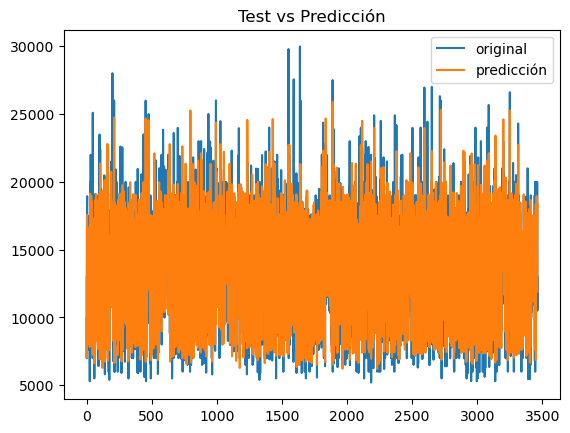

In [35]:
x_rfr = range(len(y_test))
plt.plot(x_rfr, y_test, label="original")
plt.plot(x_rfr, y_pred, label="predicción")
plt.title("Test vs Predicción")
plt.legend()
plt.show()

### conclusiones punto 5

Al calibrar los parámetros max_depth, max_features y n_estimators del modelo de Random Forest para regresión, y al comparar los resultados con el Random Forest del punto anterior se puede concluir que cada calibración del hiperparámetro afecta de forma significativa el desempeño mejorándolo. 
Si bien, se tenía un RMSE inicial de 1757, sin calibrar los tres hiperparámetros. Se observa que al modificar el max_depth a 7 el RMSE tiene una disminución significativa, pasando a 1557. Asimismo, al modificar el max_futures a 5 el RMSE sigue disminuyendo a 1557, lo cual implica un mejor poder predictivo al ser menor el error. Finalmente, cuando se modifica el n_estimator, a 31 siendo este el más óptimo, se observa que el desempeño mejora pero muy poco, obteniendo el modelo final un RMSE  de 1556. Estos resultados se observan en la gráfica que se presenta, la cual muestra la relación de la predicción del modelo con respecto al test.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [36]:
# Celda 6
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

score = xgb.score(X_train, y_train)
print("Training score: ",score)

scores = cross_val_score(xgb, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

rmse_xg = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE: %.2f" % rmse_xg)

Training score:  0.9147045779338181
Mean cross-validation score: 0.84
RMSE: 1621.42


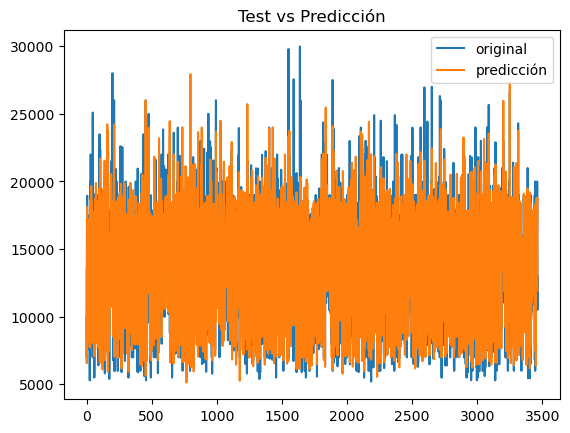

In [37]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_xgb, label="predicción")
plt.title("Test vs Predicción")
plt.legend()
plt.show()

### conclusiones punto 6

Al analizar el desempeño del modelo XGBoost quien obtuvo un valor de 1621 en el RMSE, se observa que el Random Forest del punto anteior obtuvo un mejor desempeño con un valor de 1556. Sin embargo, se destaca que obtuvo un traning score de 91% y un cross validation de 84%. 

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

## Learning Rate

In [38]:
learn_rate= [i/10 for i in range(0,10)]
listica= []

for i in learn_rate:
    xgb = XGBRegressor(learning_rate=i)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    rmse_i = np.sqrt(mean_squared_error(y_test,y_pred_xgb))
    listica.append([i,rmse_i])
    
l_rate_i = []
rmse_i= []
for i in listica:
    l_rate_i.append(i[0])
    rmse_i.append(i[1])

l_rate_df = pd.DataFrame()
l_rate_df['Learning Rate']=l_rate_i
l_rate_df['RMSE']=rmse_i

In [39]:
l_rate_df[l_rate_df['RMSE']==l_rate_df['RMSE'].min()]

,Learning Rate,RMSE
1,0.1,1562.991368


Para este caso el learning rate sera el minimo.

## Gamma

In [40]:
gamma= list(range(1,10000,1000))
listica= []

for i in gamma:
    xgb = XGBRegressor(learning_rate=0.1, gamma=i)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    rmse_i = np.sqrt(mean_squared_error(y_test,y_pred_xgb))
    listica.append([i,rmse_i])
    
gamma_i = []
rmse_i= []
for i in listica:
    gamma_i.append(i[0])
    rmse_i.append(i[1])

gamma_df = pd.DataFrame()
gamma_df['Gamma']=gamma_i
gamma_df['RMSE']=rmse_i

In [41]:
gamma_df[gamma_df['RMSE']==gamma_df['RMSE'].min()]

,Gamma,RMSE
1,1001,1562.990407


Y calibrariamos el modelo a un gamma lo suficientemente alto (1000).

## Colsample_bytree

In [42]:
cs_bytree= [i/10 for i in range(0,10)]
listica= []

for i in learn_rate:
    xgb = XGBRegressor(learning_rate=0.1,gamma=1000, colsample_bytree=i)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    rmse_i = np.sqrt(mean_squared_error(y_test,y_pred_xgb))
    listica.append([i,rmse_i])
    
cs_bytree_i = []
rmse_i= []
for i in listica:
    cs_bytree_i.append(i[0])
    rmse_i.append(i[1])

cs_bytree_df = pd.DataFrame()
cs_bytree_df['Colsample by tree']=l_rate_i
cs_bytree_df['RMSE']=rmse_i

In [43]:
cs_bytree_df[cs_bytree_df['RMSE']==cs_bytree_df['RMSE'].min()]

,Colsample by tree,RMSE
7,0.7,1548.305383


In [44]:
# Celda 7
xgbp = XGBRegressor(learning_rate = 0.1, gamma=1000, colsample_bytree=0.7)
xgbp.fit(X_train, y_train)
y_pred_xgbp = xgbp.predict(X_test)

scorep = xgbp.score(X_train, y_train)
print("Training score: ",scorep)

scoresp = cross_val_score(xgbp, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scoresp.mean())

rmse_xg2 = np.sqrt(mean_squared_error(y_test, y_pred_xgbp))
print("RMSE: %.2f" % rmse_xg2)

Training score:  0.8816862942073969
Mean cross-validation score: 0.85
RMSE: 1548.31


### conclusiones punto 7

Al calibrar los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión se observa que si tiene un efecto significativo sobre el modelo, mejorando su desempeño, pues inicialmente se tenía un RMSE de 1.621, al calibrar los hipermarámetros, se observa que, con un learning rate de 0.1	el RMSE disminuye a 1562, asímismo, cuando se modifica el parámetro de Gamma, el desempeño queda igual, pero cuando se afecta el colsample_bytree a 0.7	el modelo obtiene un RMSE final de 1548. A partir de esto, se concluye que el modelo XGBoost mejora su desempeño significativamente al optimizar sus hiperparámetros.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

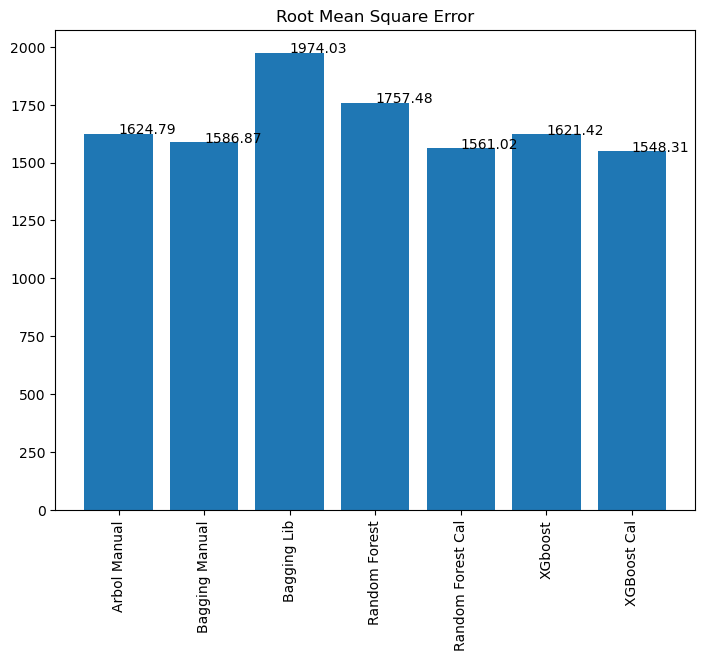

In [45]:
# Celda 8
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Root Mean Square Error")
ejeX = ['Arbol Manual','Bagging Manual','Bagging Lib','Random Forest', 'Random Forest Cal','XGboost','XGBoost Cal']
ejeY = [round(rmse_tree,2),round(rmse_bag,2),round(rmse_bag2,2),round(rmse_rf,2),round(rmse_rf2,2),round(rmse_xg,2),round(rmse_xg2,2)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=90)
plt.show()

### conclusiones punto 8

Al comparar el desempeño de los modelos anteriormente ejecutados se observa que el modelo con el mejor desempeño es el XGBoost con los hiperparámetros calibrados con un RMSE de 1548. 
Dentro de sus ventajas más significativas se encuentran que:
- se puede reducir el tamaño de los pesos del algoritmo por medio del parámetro del learning rate. 
- sus resultados son muy precisos

Por otro lado, el modelo con menor desempeño es el Bagging con libreria, con un RMSE de 1974. Este modelo presenta desventajas como:
- tiene baja precisión 
- al promediar las salidas de los modelos simples, el algoritmo no toma el mínimo error, por ende, no optimiza el desempeño.